# ARCLYTICS App Analytics  

This Jupyter Notebook is for doing some quick and dirty tests for running data analytics operations on the MongoDB and Redis data persistence. The purpose of which is to then put into a pipeline and then create endpoints for each type of query and analysis that can be done.

In [1]:
# Plotly imports

import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots

chart_studio.tools.set_credentials_file(
    username='codeninja55', 
    api_key='mLp691cLJDdKaNgJykR4'
)

chart_studio.tools.set_config_file(
    world_readable=True,
    sharing='public'
)

In [3]:
# imports
import datetime
from os import environ as env
from pymongo import MongoClient
import pandas as pd
from redis import Redis
import json 
from sklearn import manifold
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

In [4]:
# LaTeX Preamble and setting up output for reporting

# Add a logger 
# from logger.applogger import AppLogger
# logger = AppLogger("jupyterlab")

%matplotlib inline
sns.set(style='darkgrid')
# Context either: "paper", "notebook", "talk"
sns.set_context("paper", font_scale=1.0)
# matplotlib.use('PS')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (25,15)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 6
plt.rcParams['legend.fontsize'] = 10

In [6]:
conn = MongoClient(env.get('MONGO_URI'))

db_name = 'arc_dev'
collection = 'users'
db = conn[db_name]
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'arc_dev')

## Live Logged in Users

In [ ]:
date = datetime.datetime.utcnow().strftime('%Y-%m-%d')

pipeline = [
    {'$match': {'date': date}},
    {'$unwind': '$logged_in'},
    {
        '$project': {
            '_id': 0,
#             'date': '$date',
            'datetime': '$logged_in.datetime',
            'logged_in_users': '$logged_in.value'
        }
    }
]

res = db['celery_beat'].aggregate(pipeline)

df = pd.DataFrame(list(res))
df.dropna(inplace=True)

df['timestamp'] = pd.to_datetime(df['datetime'])
df.set_index('timestamp', inplace=True)

df

In [ ]:
fig = go.Figure()

trace = go.Scatter(x=df.index, y=df['logged_in_users'])

fig.add_trace(trace)

fig.update_layout(
  showlegend=False,
  title_text="Logged in Users",
#   xaxis_range=[
#     datetime.datetime(2019, 10, 4),
#     datetime.datetime(2019, 10, 5)
#   ],
  xaxis_rangeslider_visible=True
)

# fig.update_xaxes(dtick=1)
fig.update_yaxes=(tick0=0, dtick=1)

py.iplot(fig, filename='user_login_timestamps')

## Alloys Analysis

In [29]:

pipeline = [
    {'$unwind': '$saved_alloys'},
    {
        '$project': {
            '_id': 0,
            'name': '$saved_alloys.name',
            'compositions': '$saved_alloys.compositions'
        }
    },
    {'$unwind': '$compositions'},
    {
        '$replaceRoot': {
            'newRoot': '$compositions'
        }
    },
    {
        '$group': {'_id': '$symbol', 'weight': {'$addToSet': '$weight'}}
    },
    {
        '$project': {
            'weight': 1,
            '_id': 1
        }
    }
]

res = db['users'].aggregate(pipeline)

df = pd.DataFrame(list(res))

df

_id                                             weight
0   Fe                                              [0.0]
1   Nb                                              [0.0]
2   Ti                                              [0.0]
3    W                                              [0.0]
4   Ni  [0.73, 0.37, 1.9, 0.97, 0.0, 0.5, 0.04, 0.67, ...
5   Si  [0.73, 2.22, 0.892, 0.66, 0.8, 0.86, 0.92, 0.7...
6    V                                        [0.08, 0.0]
7   As                                              [0.0]
8    P                                [0.007, 0.0, 0.012]
9    B                                              [0.0]
10   C  [0.03, 0.12, 0.77, 0.32, 0.56, 0.63, 0.2, 0.73...
11  Cu                                        [0.0, 0.23]
12  Cr  [0.19, 0.65, 0.91, 0.3, 1.34, 0.78, 0.1, 0.51,...
13   N                                       [0.011, 0.0]
14   S                                 [0.003, 0.0, 0.04]
15  Al                                              [0.0]
16  Mo  [0.46, 1.1, 1.26, 0.39, 0.0, 0.4, 0.5, 0.6, 0.26]
17  Mn  [1.98, 0.21, 1.04, 0.42, 0.54, 1.0, 0.82, 1.03...
18  Co                                   [0.75, 0.0, 0.5]

In [78]:
pipeline = [
    {'$unwind': '$saved_alloys'},
    {
        '$project': {
            '_id': 0,
            'name': '$saved_alloys.name',
            'compositions': '$saved_alloys.compositions'
        }
    },
]

res = db['users'].aggregate(pipeline)

pd.DataFrame(list(res))

# for i in res:
#   print(i)

name                                       compositions
0                Ionite  [{'symbol': 'C', 'weight': 0.36}, {'symbol': '...
1              Kayaleco  [{'symbol': 'C', 'weight': 0.21}, {'symbol': '...
2              Aegolong  [{'symbol': 'C', 'weight': 0.6}, {'symbol': 'M...
3           Chloneotime  [{'symbol': 'C', 'weight': 0.31}, {'symbol': '...
4              New Tech  [{'symbol': 'C', 'weight': 0.53}, {'symbol': '...
...                 ...                                                ...
2366          New Alloy  [{'symbol': 'C', 'weight': 0.5}, {'symbol': 'M...
2367           Nanotech  [{'symbol': 'C', 'weight': 0.344}, {'symbol': ...
2368          alloy-987  [{'symbol': 'C', 'weight': 0.32}, {'symbol': '...
2369  Wakanda Vibranium  [{'symbol': 'C', 'weight': 0.044}, {'symbol': ...
2370           Aegolong  [{'symbol': 'C', 'weight': 0.6}, {'symbol': 'M...

[2371 rows x 2 columns]

In [210]:
pipeline = [
    {'$unwind': '$saved_alloys'},
    {
        '$project': {
            '_id': 1,
            'name': '$saved_alloys.name',
            'compositions': '$saved_alloys.compositions'
        }
    },
    {'$unwind': { 'path': '$compositions', 'includeArrayIndex': 'arrayIndex'}},
    {
        '$group': {
            '_id': '$_id',
            'symbol': { '$push': { 'elem': '$compositions.symbol' } },
            'weight': { '$push': { 'wt': '$compositions.weight' } }
        }
    }
  
]

res = db['users'].aggregate(pipeline)

pd.DataFrame(list(res))

_id  \
0    5dabd0ee4057508cb545e051   
1    5dabd0ee4057508cb545e024   
2    5dabd0ee4057508cb545e005   
3    5dabd0bf4057508cb545d03f   
4    5dabd0bd4057508cb545cfca   
..                        ...   
197  5dabd0e94057508cb545de78   
198  5dabd0e94057508cb545de27   
199  5dabd0974057508cb545c260   
200  5dabd0ea4057508cb545deb7   
201  5dabd0eb4057508cb545df09   

                                                symbol  \
0    [{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...   
1    [{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...   
2    [{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...   
3    [{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...   
4    [{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...   
..                                                 ...   
197  [{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...   
198  [{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...   
199  [{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...   
200  [{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...   
201  [{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...   

                                                weight  
0    [{'wt': 0.5}, {'wt': 0.64}, {'wt': 0.87}, {'wt...  
1    [{'wt': 0.56}, {'wt': 1.1}, {'wt': 0.13}, {'wt...  
2    [{'wt': 0.21}, {'wt': 1.2}, {'wt': 0.43}, {'wt...  
3    [{'wt': 0.094}, {'wt': 1.03}, {'wt': 1.42}, {'...  
4    [{'wt': 0.31}, {'wt': 0.82}, {'wt': 0.43}, {'w...  
..                                                 ...  
197  [{'wt': 0.3}, {'wt': 0.78}, {'wt': 1.6}, {'wt'...  
198  [{'wt': 0.12}, {'wt': 0.21}, {'wt': 0.892}, {'...  
199  [{'wt': 0.32}, {'wt': 0.39}, {'wt': 0.83}, {'w...  
200  [{'wt': 0.044}, {'wt': 1.73}, {'wt': 0.22}, {'...  
201  [{'wt': 0.094}, {'wt': 1.03}, {'wt': 1.42}, {'...  

[202 rows x 3 columns]

In [7]:
pipeline = [
    {'$unwind': '$saved_alloys'},
  
    {
        '$project': {
            '_id': 1,
            'name': '$saved_alloys.name',
            'compositions': '$saved_alloys.compositions'
        }
    },
  
    {'$unwind': '$compositions'},
  
    {
        '$group': {
            '_id': { 'id': '$_id', 'name':  '$name' },
            'items': { 
                '$addToSet': { 'name': '$compositions.symbol', 'value': '$compositions.weight' } 
            },
        }
    },
  
    {
      '$project': {
          'tmp': {
              '$arrayToObject': {
                  '$zip': { 'inputs': [ "$items.name", "$items.value" ] }
              }
          }
      }
  },
  
  {
      '$addFields': { 'tmp.name': '$_id.name'}
  }, 
  
  { 
      '$replaceRoot': { 'newRoot': '$tmp' }
  }
]

res = db['users'].aggregate(pipeline)
df = pd.DataFrame(list(res))
df = df.fillna(0)
df.head()

Fe      P    B    N   Nb    W    V    Ni    Cr    Si   Ti    Mn   Al  \
0  0.0  0.012  0.0  0.0  0.0  0.0  0.0  0.50  0.10  0.93  0.0  0.42  0.0   
1  0.0  0.000  0.0  0.0  0.0  0.0  0.0  0.34  0.76  0.42  0.0  0.32  0.0   
2  0.0  0.012  0.0  0.0  0.0  0.0  0.0  0.20  0.30  0.03  0.0  0.61  0.0   
3  0.0  0.000  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.22  0.0  1.73  0.0   
4  0.0  0.012  0.0  0.0  0.0  0.0  0.0  0.04  0.20  0.38  0.0  0.84  0.0   

     Mo   As     S      C   Co    Cu                     name  
0  0.00  0.0  0.04  0.630  0.5  0.23                 Locotech  
1  1.26  0.0  0.00  0.710  0.0  0.00                 Alloy-12  
2  0.00  0.0  0.04  0.690  0.0  0.23               Adamantium  
3  0.26  0.0  0.00  0.044  0.0  0.00  Thanos Killing Nanotech  
4  0.00  0.0  0.04  0.600  0.5  0.23                 Aegolong

In [8]:
# Standardising the data
features = ['grain_size', 'ms_temp', 'ms_rate_param', 'bs_temp', 'ae1_temp', 'ae3_temp']

from sklearn.preprocessing import MinMaxScaler

# Separating out the target
labels_df = pd.DataFrame(data=df['name'].values, columns=['name'])
labels_df.reset_index(drop=True, inplace=True)

# Separating out the features
df.drop(['name'], axis=1, inplace=True)
X = df.loc[:].values

len(X)

2531

In [9]:
len(X[0])

19

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_embedded = tsne.fit_transform(X)

# create a new aggregated dataframe to store the results
tsne_df = pd.DataFrame(data=tsne_embedded, columns=['x-tsne', 'y-tsne'])
tsne_df.reset_index(drop=True, inplace=True)
tsne_df = pd.concat([tsne_df, labels_df], axis=1, ignore_index=True)
tsne_df.columns = ['x-tsne', 'y-tsne', 'name']


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2531 samples in 0.006s...
[t-SNE] Computed neighbors for 2531 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2531
[t-SNE] Computed conditional probabilities for sample 2000 / 2531
[t-SNE] Computed conditional probabilities for sample 2531 / 2531
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.141438
[t-SNE] KL divergence after 2000 iterations: -0.034788


In [11]:
import pprint

# Check the results
pprint.pprint(tsne.get_params())
print("t-SNE Data Shape: {}".format(str(tsne_df.shape)))
# tsne_df.head()

params = tsne.get_params()

params

{'angle': 0.5,
 'early_exaggeration': 12.0,
 'init': 'random',
 'learning_rate': 200.0,
 'method': 'barnes_hut',
 'metric': 'euclidean',
 'min_grad_norm': 1e-07,
 'n_components': 2,
 'n_iter': 2000,
 'n_iter_without_progress': 300,
 'perplexity': 40,
 'random_state': None,
 'verbose': 1}
t-SNE Data Shape: (2531, 3)


{'angle': 0.5,
 'early_exaggeration': 12.0,
 'init': 'random',
 'learning_rate': 200.0,
 'method': 'barnes_hut',
 'metric': 'euclidean',
 'min_grad_norm': 1e-07,
 'n_components': 2,
 'n_iter': 2000,
 'n_iter_without_progress': 300,
 'perplexity': 40,
 'random_state': None,
 'verbose': 1}

In [ ]:
tsne_df = tsne_df.assign(color=(tsne_df['name').astype('category').cat.codes)

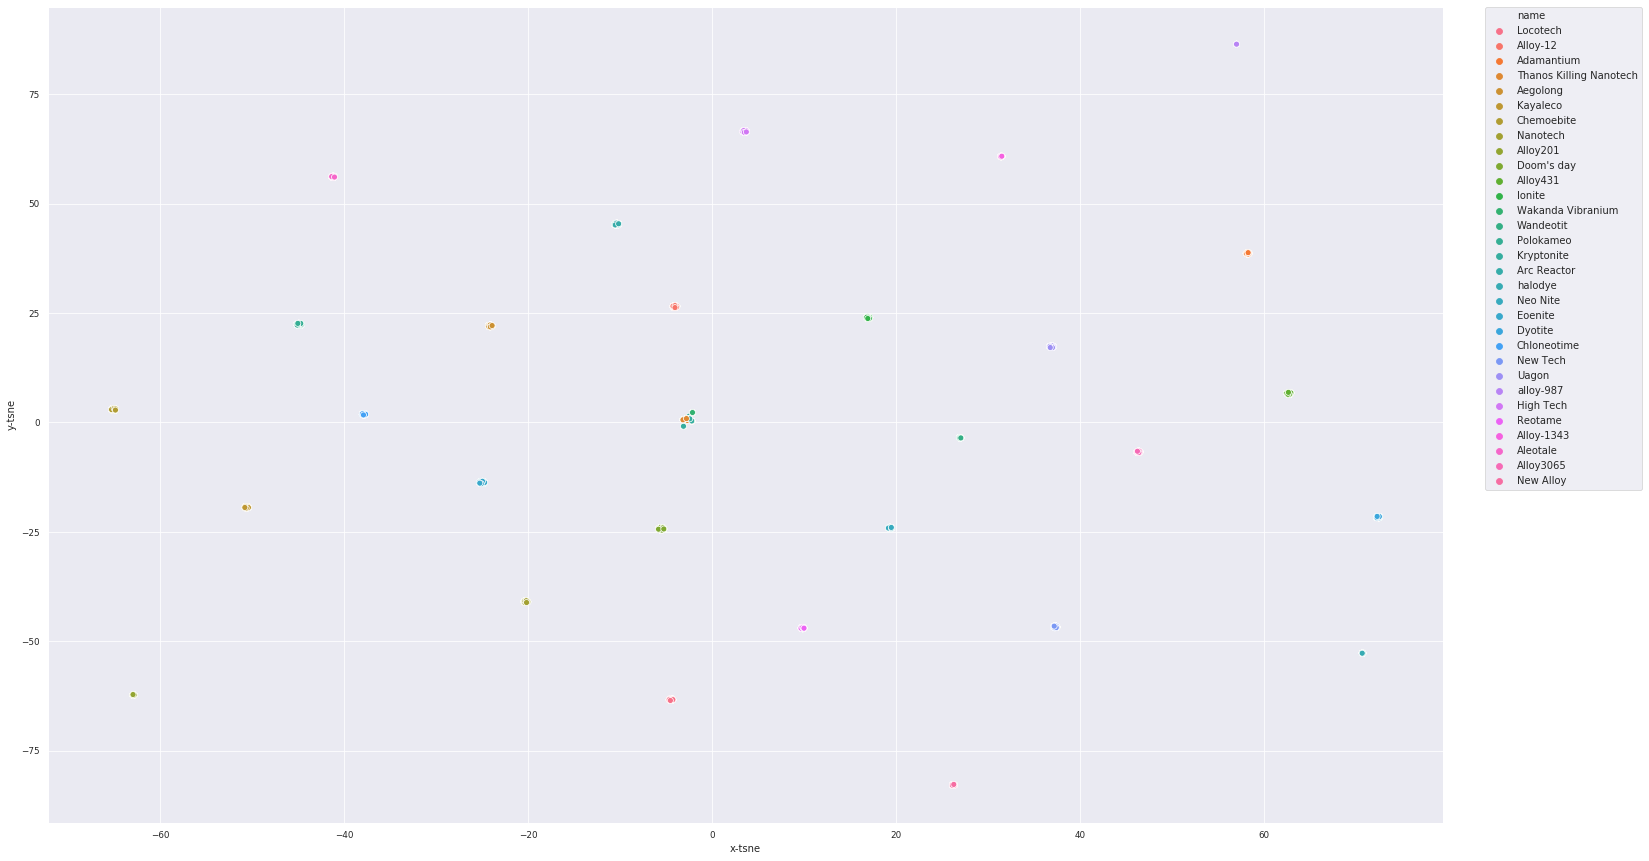

In [12]:
tsne_plot = sns.scatterplot(x='x-tsne', y='y-tsne', data=tsne_df, hue='name')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)

### MDS

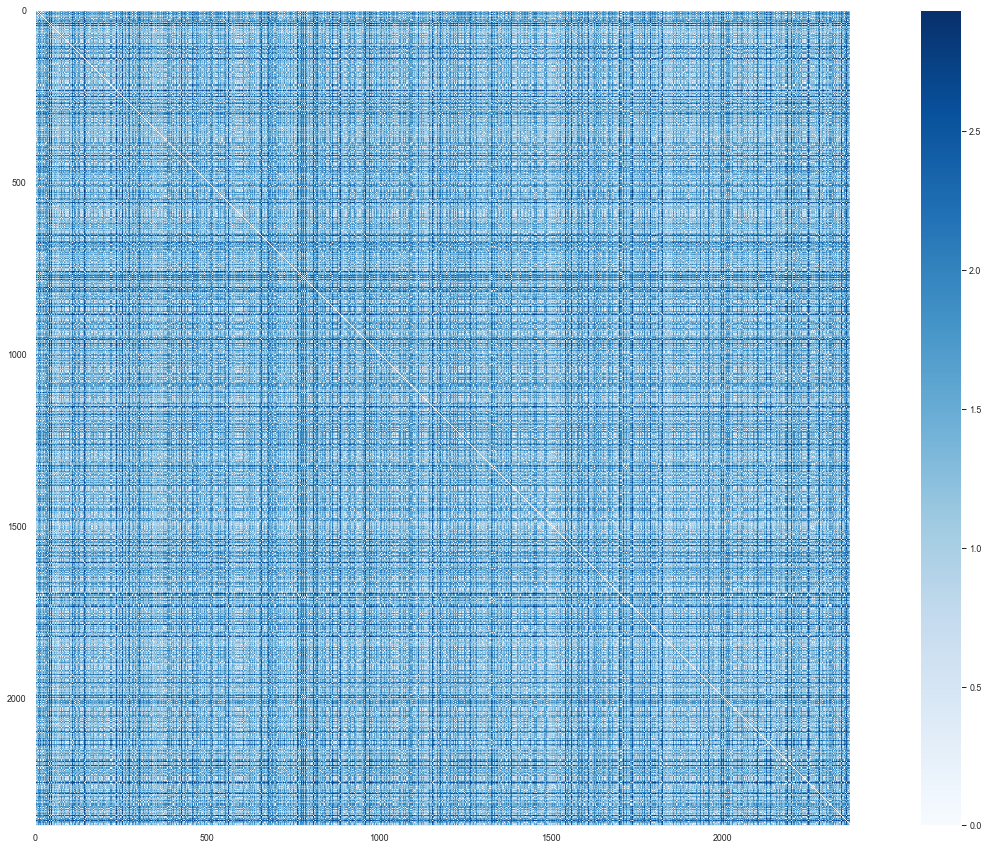

In [245]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)

plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

In [246]:
from sklearn.manifold import MDS

model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)

out

array([[ 0.51127611, -0.02292463],
       [ 0.85842418, -0.99930012],
       [-0.12457411,  0.05331104],
       ...,
       [-0.89616483, -1.84022235],
       [-0.56131739,  0.62828362],
       [-0.45948182,  0.62181703]])

(-1.8912756534671629,
 1.584802344604593,
 -1.9952787530948943,
 1.335020327791395)

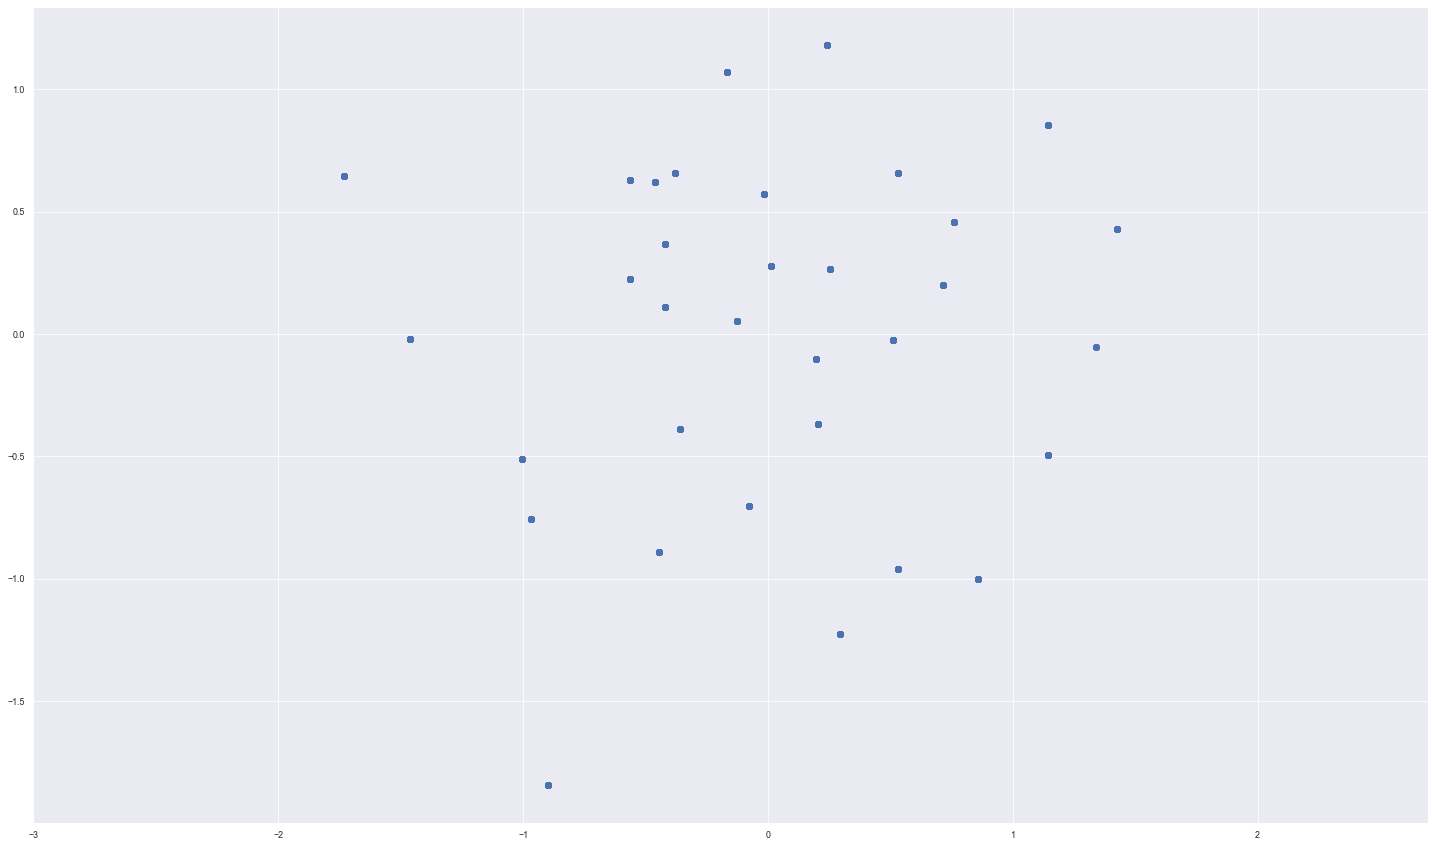

In [247]:
plt.scatter(out[:, 0], out[:, 1])
plt.axis('equal')

## Saved Simulations by Alloy

In [276]:
pipeline = [
    {
        '$project': {
            '_id': 0,
        }
    }
]

res = db['saved_simulations'].aggregate(pipeline)
pd.DataFrame(list(res))

user  \
0     5dac1b9b2a68854f0b8a1516   
1     5dac1b9b2a68854f0b8a1516   
2     5dac1b9b2a68854f0b8a1516   
3     5dac1b9b2a68854f0b8a1516   
4     5dac1b9b2a68854f0b8a1516   
...                        ...   
1084  5dac1bf62a68854f0b8a3485   
1085  5dac1bf62a68854f0b8a3485   
1086  5dac1bf62a68854f0b8a34a8   
1087  5dac1bf62a68854f0b8a34a8   
1088  5dac1bf62a68854f0b8a34a8   

                                         configurations  \
0     {'is_valid': False, 'method': 'Kirkaldy83', 'g...   
1     {'is_valid': False, 'method': 'Kirkaldy83', 'g...   
2     {'is_valid': False, 'method': 'Li98', 'grain_s...   
3     {'is_valid': False, 'method': 'Kirkaldy83', 'g...   
4     {'is_valid': False, 'method': 'Li98', 'grain_s...   
...                                                 ...   
1084  {'is_valid': False, 'method': 'Kirkaldy83', 'g...   
1085  {'is_valid': False, 'method': 'Kirkaldy83', 'g...   
1086  {'is_valid': False, 'method': 'Kirkaldy83', 'g...   
1087  {'is_valid': False, 'method': 'Kirkaldy83', 'g...   
1088  {'is_valid': False, 'method': 'Li98', 'grain_s...   

                                            alloy_store  \
0     {'alloy_option': 'single', 'alloys': {'parent'...   
1     {'alloy_option': 'single', 'alloys': {'parent'...   
2     {'alloy_option': 'single', 'alloys': {'parent'...   
3     {'alloy_option': 'single', 'alloys': {'parent'...   
4     {'alloy_option': 'single', 'alloys': {'parent'...   
...                                                 ...   
1084  {'alloy_option': 'single', 'alloys': {'parent'...   
1085  {'alloy_option': 'single', 'alloys': {'parent'...   
1086  {'alloy_option': 'single', 'alloys': {'parent'...   
1087  {'alloy_option': 'single', 'alloys': {'parent'...   
1088  {'alloy_option': 'single', 'alloys': {'parent'...   

                                     simulation_results  \
0     {'TTT': {'bainite_completion': {'temp': [478, ...   
1     {'TTT': {'bainite_completion': {'temp': [369, ...   
2     {'TTT': {'bainite_completion': {'temp': [221, ...   
3     {'TTT': {'bainite_completion': {'temp': [478, ...   
4     {'TTT': {'bainite_completion': {'temp': [365, ...   
...                                                 ...   
1084  {'TTT': {'bainite_completion': {'temp': [478, ...   
1085  {'TTT': {'bainite_completion': {'temp': [205, ...   
1086  {'TTT': {'bainite_completion': {'temp': [369, ...   
1087  {'TTT': {'bainite_completion': {'temp': [478, ...   
1088  {'TTT': {'bainite_completion': {'temp': [329, ...   

                     created  
0    2019-10-20 08:32:27.418  
1    2019-10-20 08:32:27.418  
2    2019-10-20 08:32:27.418  
3    2019-10-20 08:32:27.418  
4    2019-10-20 08:32:27.418  
...                      ...  
1084 2019-10-20 08:32:27.418  
1085 2019-10-20 08:32:27.418  
1086 2019-10-20 08:32:27.418  
1087 2019-10-20 08:32:27.418  
1088 2019-10-20 08:32:27.418  

[1089 rows x 5 columns]

In [ ]:
pipeline = [
    {
        '$replaceRoot': {
            'newRoot': '$simulation_results'
        }
    }   
]

res = db['saved_simulations'].aggregate(pipeline)
pd.DataFrame(list(res))

In [277]:
pipeline = [
    {
        '$project': {
            '_id': 0,
            'configs': '$configurations'
        }
    },
    {
        '$replaceRoot': {
            'newRoot': '$configs'
        }
    }   
]

res = db['saved_simulations'].aggregate(pipeline)
pd.DataFrame(list(res))

is_valid      method  grain_size  nucleation_start  nucleation_finish  \
0        False  Kirkaldy83         8.0               1.0               99.9   
1        False  Kirkaldy83         8.0               1.0               99.9   
2        False        Li98         8.0               1.0               99.9   
3        False  Kirkaldy83         8.0               1.0               99.9   
4        False        Li98         8.0               1.0               99.9   
...        ...         ...         ...               ...                ...   
1084     False  Kirkaldy83         8.0               1.0               99.9   
1085     False  Kirkaldy83         8.0               1.0               99.9   
1086     False  Kirkaldy83         8.0               1.0               99.9   
1087     False  Kirkaldy83         8.0               1.0               99.9   
1088     False        Li98         8.0               1.0               99.9   

      auto_calculate_ms  auto_calculate_bs  auto_calculate_ae   ms_temp  \
0                  True               True               True  477.5753   
1                  True               True               True  369.4817   
2                  True               True               True  221.2202   
3                  True               True               True  477.5753   
4                  True               True               True  364.7500   
...                 ...                ...                ...       ...   
1084               True               True               True  477.5753   
1085               True               True               True  205.3423   
1086               True               True               True  369.4817   
1087               True               True               True  477.5753   
1088               True               True               True  328.8028   

      ms_rate_param   bs_temp  ae1_temp  ae3_temp  start_temp  \
0            0.0207  565.7230  700.8947  845.8189         900   
1            0.0194  539.3523  676.7499  761.7874         900   
2            0.0145  562.4373  713.2084  723.5708         900   
3            0.0207  565.7230  700.8947  845.8189         900   
4            0.0194  535.3486  676.7499  761.7874         900   
...             ...       ...       ...       ...         ...   
1084         0.0207  565.7230  700.8947  845.8189         900   
1085         0.0145  579.1873  713.2084  723.5708         900   
1086         0.0194  539.3523  676.7499  761.7874         900   
1087         0.0207  565.7230  700.8947  845.8189         900   
1088         0.0184  516.8679  731.4592  774.6541         900   

      cct_cooling_rate  
0                   10  
1                   10  
2                   10  
3                   10  
4                   10  
...                ...  
1084                10  
1085                10  
1086                10  
1087                10  
1088                10  

[1089 rows x 15 columns]

In [ ]:
# Saved simulation by alloy name
pipeline = [
    {
        '$replaceRoot': {
            'newRoot': '$alloy_store.alloys.parent'
        }
    }   
]

res = db['saved_simulations'].aggregate(pipeline)
pd.DataFrame(list(res))

## Method Count

In [279]:
pipeline = [
    {
        '$project': {
            '_id': 0,
            'configs': '$configurations'
        }
    },
    {
        '$group': {
          '_id': '$configs.method',
          'count': { '$sum': 1 }
        }
    },
]

res = db['saved_simulations'].aggregate(pipeline)
pd.DataFrame(list(res))

_id  count
0  None   1089

## Alloy Name Count

In [275]:
# Saved simulation by alloy name
pipeline = [
    {
        '$project': {
            '_id': 0,
            'alloy': '$alloy_store.alloys.parent'
        }
    },
    {
        '$group': {
          '_id': '$alloy.name',
          'count': { '$sum': 1 }
        }
    },
]

res = db['saved_simulations'].aggregate(pipeline)
df = pd.DataFrame(list(res))
df

_id  count
0     330M Alloy1    227
1     300M Alloy2    223
2    Class1_Steel    213
3  Bohemen Alloy1    208
4  Bohemen Alloy2    218

In [274]:
# Saved simulation by alloy name
pipeline = [
    {
        '$project': {
            '_id': 0,
            'alloy': '$alloy_store.alloys.parent'
        }
    },
    {
        '$group': {
          '_id': '$alloy.name',
          'count': { '$sum': 1 }
        }
    },
]

res = db['shared_simulations'].aggregate(pipeline)
pd.DataFrame(list(res))

_id  count
0     300M Alloy2     95
1    Class1_Steel     93
2  Bohemen Alloy1     78
3  Bohemen Alloy2     82
4     330M Alloy1     75

## MDS on Simulation Configurations

In [ ]:
pipeline = [
    {
        '$project': {
            '_id': 0,
            'method': '$configurations.method',
            'grain_size': '$configurations.grain_size',
            'ms_temp': '$configurations.ms_temp',
            'ms_rate_param': '$configurations.ms_rate_param',
            'bs_temp': '$configurations.bs_temp',
            'ae1_temp': '$configurations.ae1_temp',
            'ae3_temp': '$configurations.ae3_temp',
        }
    }
]

res = db['saved_simulations'].aggregate(pipeline)
df = pd.DataFrame(list(res))

df = pd.get_dummies(df)
df.head()

In [ ]:

iso = manifold.Isomap(n_neighbors=2, n_components=2)

iso.fit(df)

manifold_2Da = iso.transform(df)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])

# Left with 2 dimensions
manifold_2D.head()

In [ ]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(df)

plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

In [ ]:
from sklearn.manifold import MDS

model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)

out

In [ ]:
plt.scatter(out[:, 0], out[:, 1])
plt.axis('equal')

In [160]:
pipeline = [
    {
        '$project': {
            '_id': 0,
            'method': '$configurations.method',
            'grain_size': '$configurations.grain_size',
            'ms_temp': '$configurations.ms_temp',
            'ms_rate_param': '$configurations.ms_rate_param',
            'bs_temp': '$configurations.bs_temp',
            'ae1_temp': '$configurations.ae1_temp',
            'ae3_temp': '$configurations.ae3_temp',
        }
    }
]

res = db['saved_simulations'].aggregate(pipeline)
df = pd.DataFrame(list(res))


In [161]:
# Standardising the data
features = ['grain_size', 'ms_temp', 'ms_rate_param', 'bs_temp', 'ae1_temp', 'ae3_temp']

from sklearn.preprocessing import MinMaxScaler

# Separating out the features
x = df.loc[:, features].values
# Separating out the target
labels_df = pd.DataFrame(data=df['method'].values, columns=['method'])
labels_df.reset_index(drop=True, inplace=True)

# An alternative standardization is scaling features to lie between a given minimum and maximum value, often between 
# zero and one, or so that the maximum absolute value of each feature is scaled to unit size. This can be achieved 
# using MinMaxScaler or MaxAbsScaler, respectively.
# The motivation to use this scaling include robustness to very small standard deviations of features and preserving 
# zero entries in sparse data.
minmax_scaler = MinMaxScaler()

# x = standard_scaler.fit_transform(x)
x = minmax_scaler.fit_transform(x)
x

array([[0.        , 0.45351041, 0.62903226, 0.61835163, 1.        ,
        0.4178658 ],
       [0.        , 0.95079178, 1.        , 0.90222004, 0.44132899,
        1.        ],
       [0.        , 1.        , 1.        , 0.91754368, 0.44132899,
        1.        ],
       ...,
       [0.        , 0.95079178, 1.        , 0.90222004, 0.44132899,
        1.        ],
       [0.        , 0.48390386, 0.62903226, 0.        , 1.        ,
        0.4178658 ],
       [0.        , 0.05832467, 0.        , 0.89742183, 0.66640407,
        0.        ]])

In [162]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principal_components = pca.fit_transform(x)
print("Components: {}".format(str(pca.components_)))
print("Variance: {}".format(str(pca.explained_variance_)))
print("Variance Ratio: {}".format(str(pca.explained_variance_ratio_)))

# create a new aggregated dataframe to store the results
pca_df = pd.DataFrame(data=principal_components, columns=['0', '1'])
pca_df.reset_index(drop=True, inplace=True)
pca_df = pd.concat([pca_df, labels_df], axis=1, ignore_index=True)
pca_df.columns = ['pc_1', 'pc_2', 'supplier']

pca_df.head()

Components: [[-0.         -0.5489567  -0.5597518  -0.06780523  0.20488222 -0.58202251]
 [-0.          0.05826663  0.08780855 -0.58318526  0.77949257  0.20293087]]
Variance: [0.41431746 0.12691352]
Variance Ratio: [0.68383843 0.20947306]


pc_1      pc_2    supplier
0  0.281994  0.425165        Li98
1 -0.671167  0.003819        Li98
2 -0.699219 -0.002250  Kirkaldy83
3  1.032035 -0.223899  Kirkaldy83
4 -0.671167  0.003819        Li98

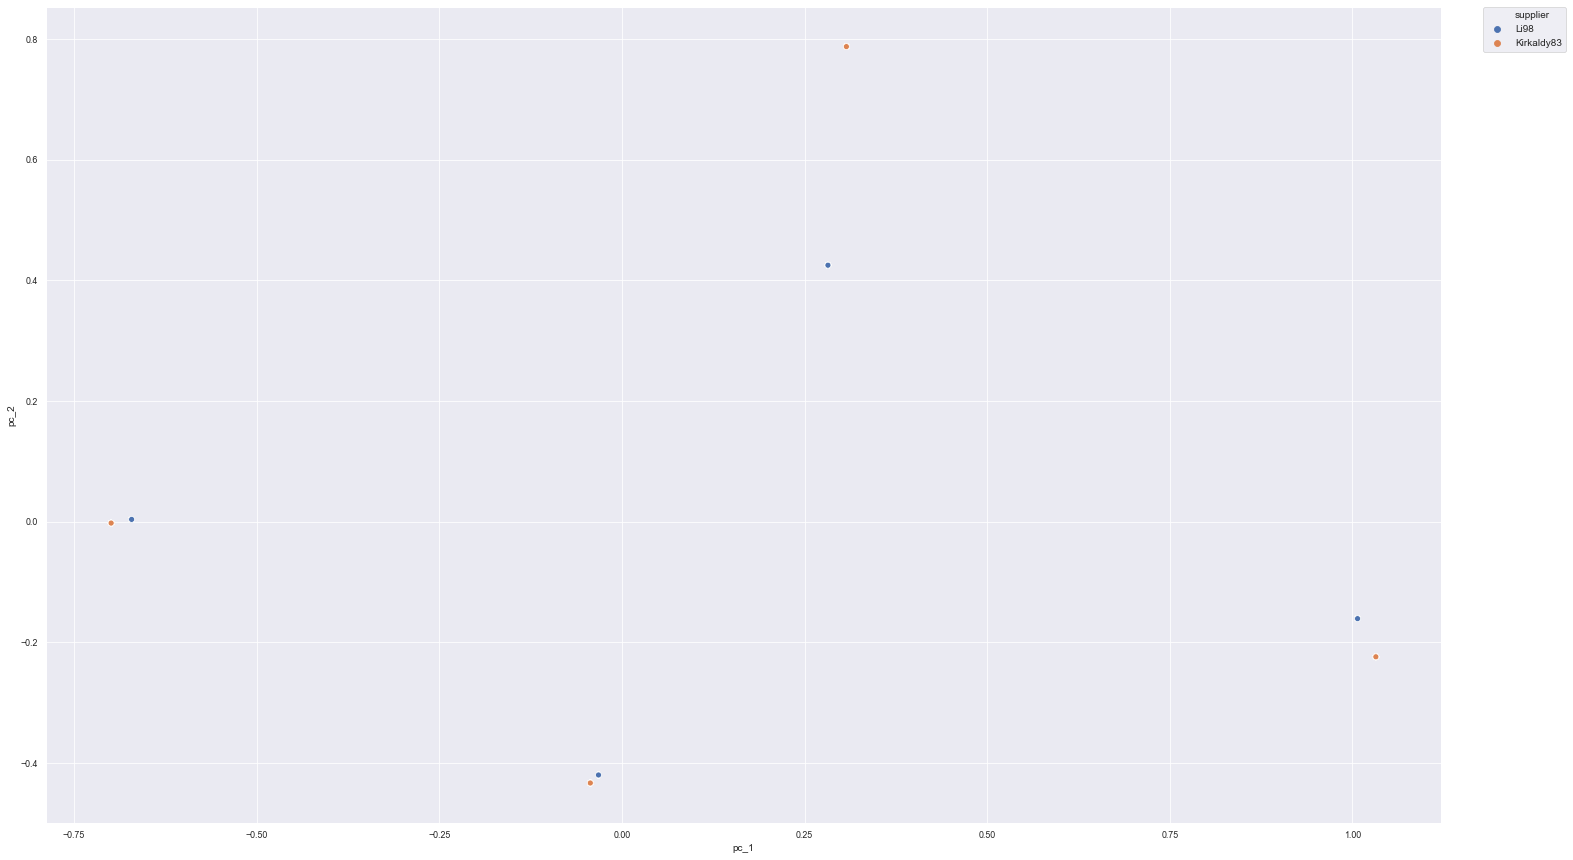

In [163]:
# Plotting the PCA
pca_plot = sns.scatterplot(x='pc_1', y='pc_2', data=pca_df, hue='supplier')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
# pca_plot.figure.savefig("plots/pca_plot-1.png")

In [164]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_embedded = tsne.fit_transform(x)

# create a new aggregated dataframe to store the results
tsne_df = pd.DataFrame(data=tsne_embedded, columns=['x-tsne', 'y-tsne'])
tsne_df.reset_index(drop=True, inplace=True)
tsne_df = pd.concat([tsne_df, labels_df], axis=1, ignore_index=True)
tsne_df.columns = ['x-tsne', 'y-tsne', 'method']

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1064 samples in 0.001s...
[t-SNE] Computed neighbors for 1064 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1064
[t-SNE] Computed conditional probabilities for sample 1064 / 1064
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 32.586693
[t-SNE] KL divergence after 2000 iterations: -0.040617


In [165]:
import pprint

# Check the results
pprint.pprint(tsne.get_params())
print("t-SNE Data Shape: {}".format(str(tsne_df.shape)))
tsne_df.head()

{'angle': 0.5,
 'early_exaggeration': 12.0,
 'init': 'random',
 'learning_rate': 200.0,
 'method': 'barnes_hut',
 'metric': 'euclidean',
 'min_grad_norm': 1e-07,
 'n_components': 2,
 'n_iter': 2000,
 'n_iter_without_progress': 300,
 'perplexity': 40,
 'random_state': None,
 'verbose': 1}
t-SNE Data Shape: (1064, 3)


x-tsne     y-tsne      method
0   0.570783 -32.931080        Li98
1 -23.004627   3.847154        Li98
2  18.225039   0.872933  Kirkaldy83
3 -24.260855  52.080254  Kirkaldy83
4 -23.004627   3.847154        Li98

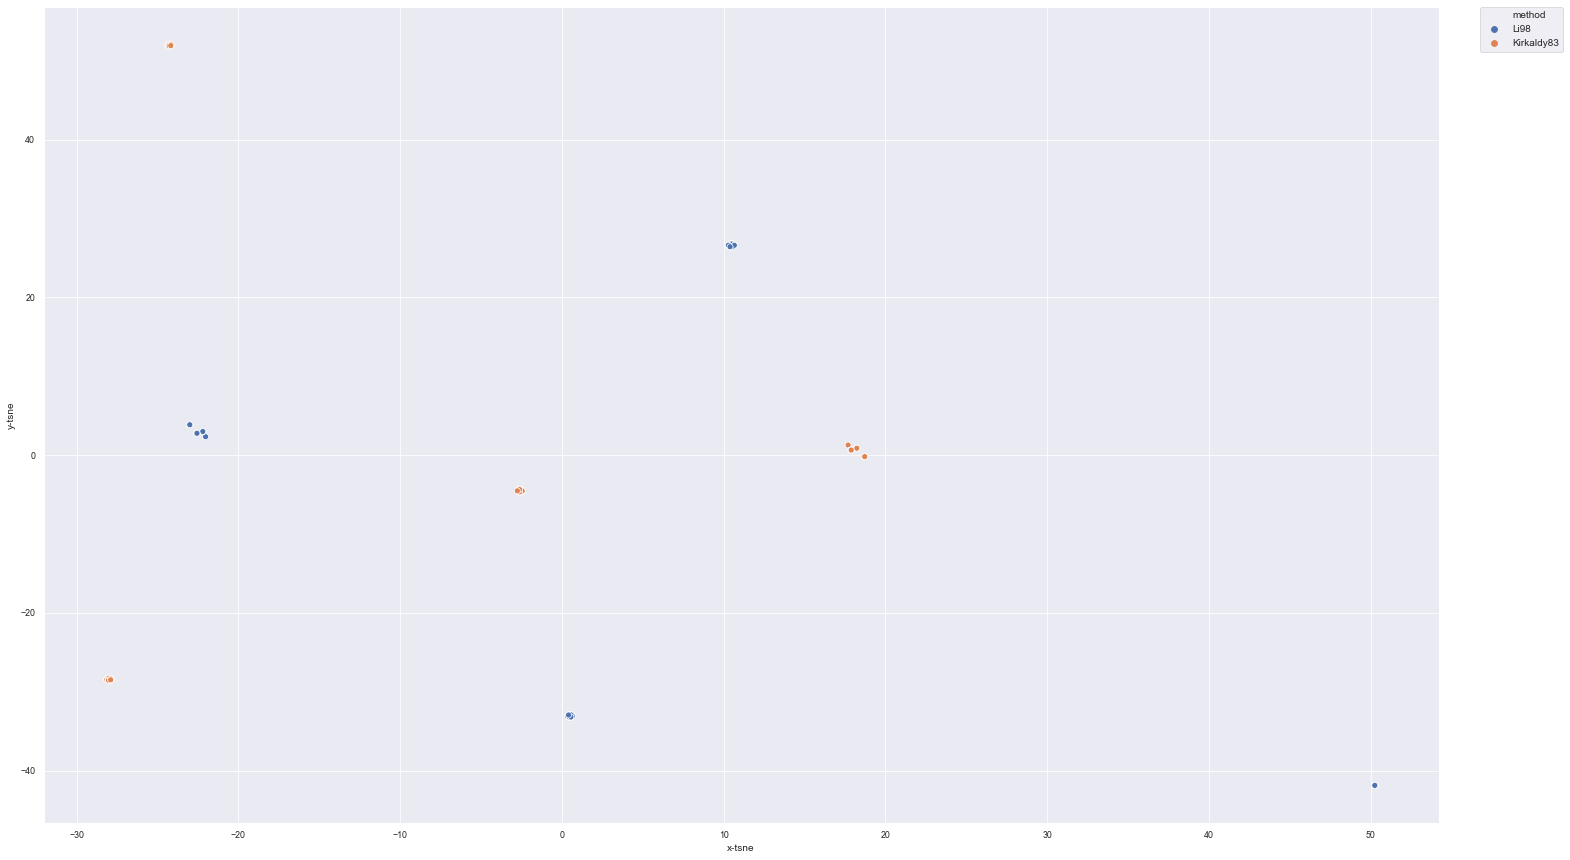

In [166]:
tsne_plot = sns.scatterplot(x='x-tsne', y='y-tsne', data=tsne_df, hue='method')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)